In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage

### Step 1: EDA

In [2]:
conn = sqlite3.connect('../data/prochlorococcus/Prochlorococcus-PAN-PAN.db')

query = "SELECT * FROM gene_cluster_presence_absence"

df = pd.read_sql_query(query, conn)

conn.close()

In [35]:
pivot_df = df.pivot(index='layer', columns='item', values='value')

# transpose data
pivot_df = pivot_df.T
print("Data shape:", pivot_df.shape)
pivot_df.head()

Data shape: (7385, 31)


layer        AS9601  CCMP1375  EQPAC1  GP2  LG  MED4  MIT9107  MIT9116  \
item                                                                     
PC_00000001       1         1       1    1   1     1        1        1   
PC_00000002       1         1       1    1   1     1        1        1   
PC_00000003       1         1       1    1   1     1        1        1   
PC_00000004       1         0       1    1   0     1        1        1   
PC_00000005       1         1       1    1   1     1        1        1   

layer        MIT9123  MIT9201  ...  MIT9322  MIT9401  MIT9515  NATL1A  NATL2A  \
item                           ...                                              
PC_00000001        1        1  ...        1        1        1       1       1   
PC_00000002        1        1  ...        1        1        1       1       1   
PC_00000003        1        1  ...        1        1        1       1       1   
PC_00000004        1        1  ...        1        1        1       1       1   
PC_00000005        1        1  ...        1        1        1       1       1   

layer        PAC1  SB  SS2  SS35  SS51  
item                                    
PC_00000001     1   1    1     1     1  
PC_00000002     1   1    1     1     1  
PC_00000003     1   1    1     1     1  
PC_00000004     1   1    0     0     0  
PC_00000005     1   1    1     1     1  

[5 rows x 31 columns]

In [17]:
# Hierarchical clustering for rows
row_linkage = sch.linkage(pivot_df, method="complete", metric="jaccard")
row_order = sch.dendrogram(row_linkage, no_plot=True)['leaves']

# Hierarchical clustering for columns
col_linkage = sch.linkage(pivot_df.transpose(), method="complete", metric="jaccard")
col_order = sch.dendrogram(col_linkage, no_plot=True)['leaves']

# Reorder both rows and columns
pivot_df_clustered = pivot_df.iloc[row_order, col_order]

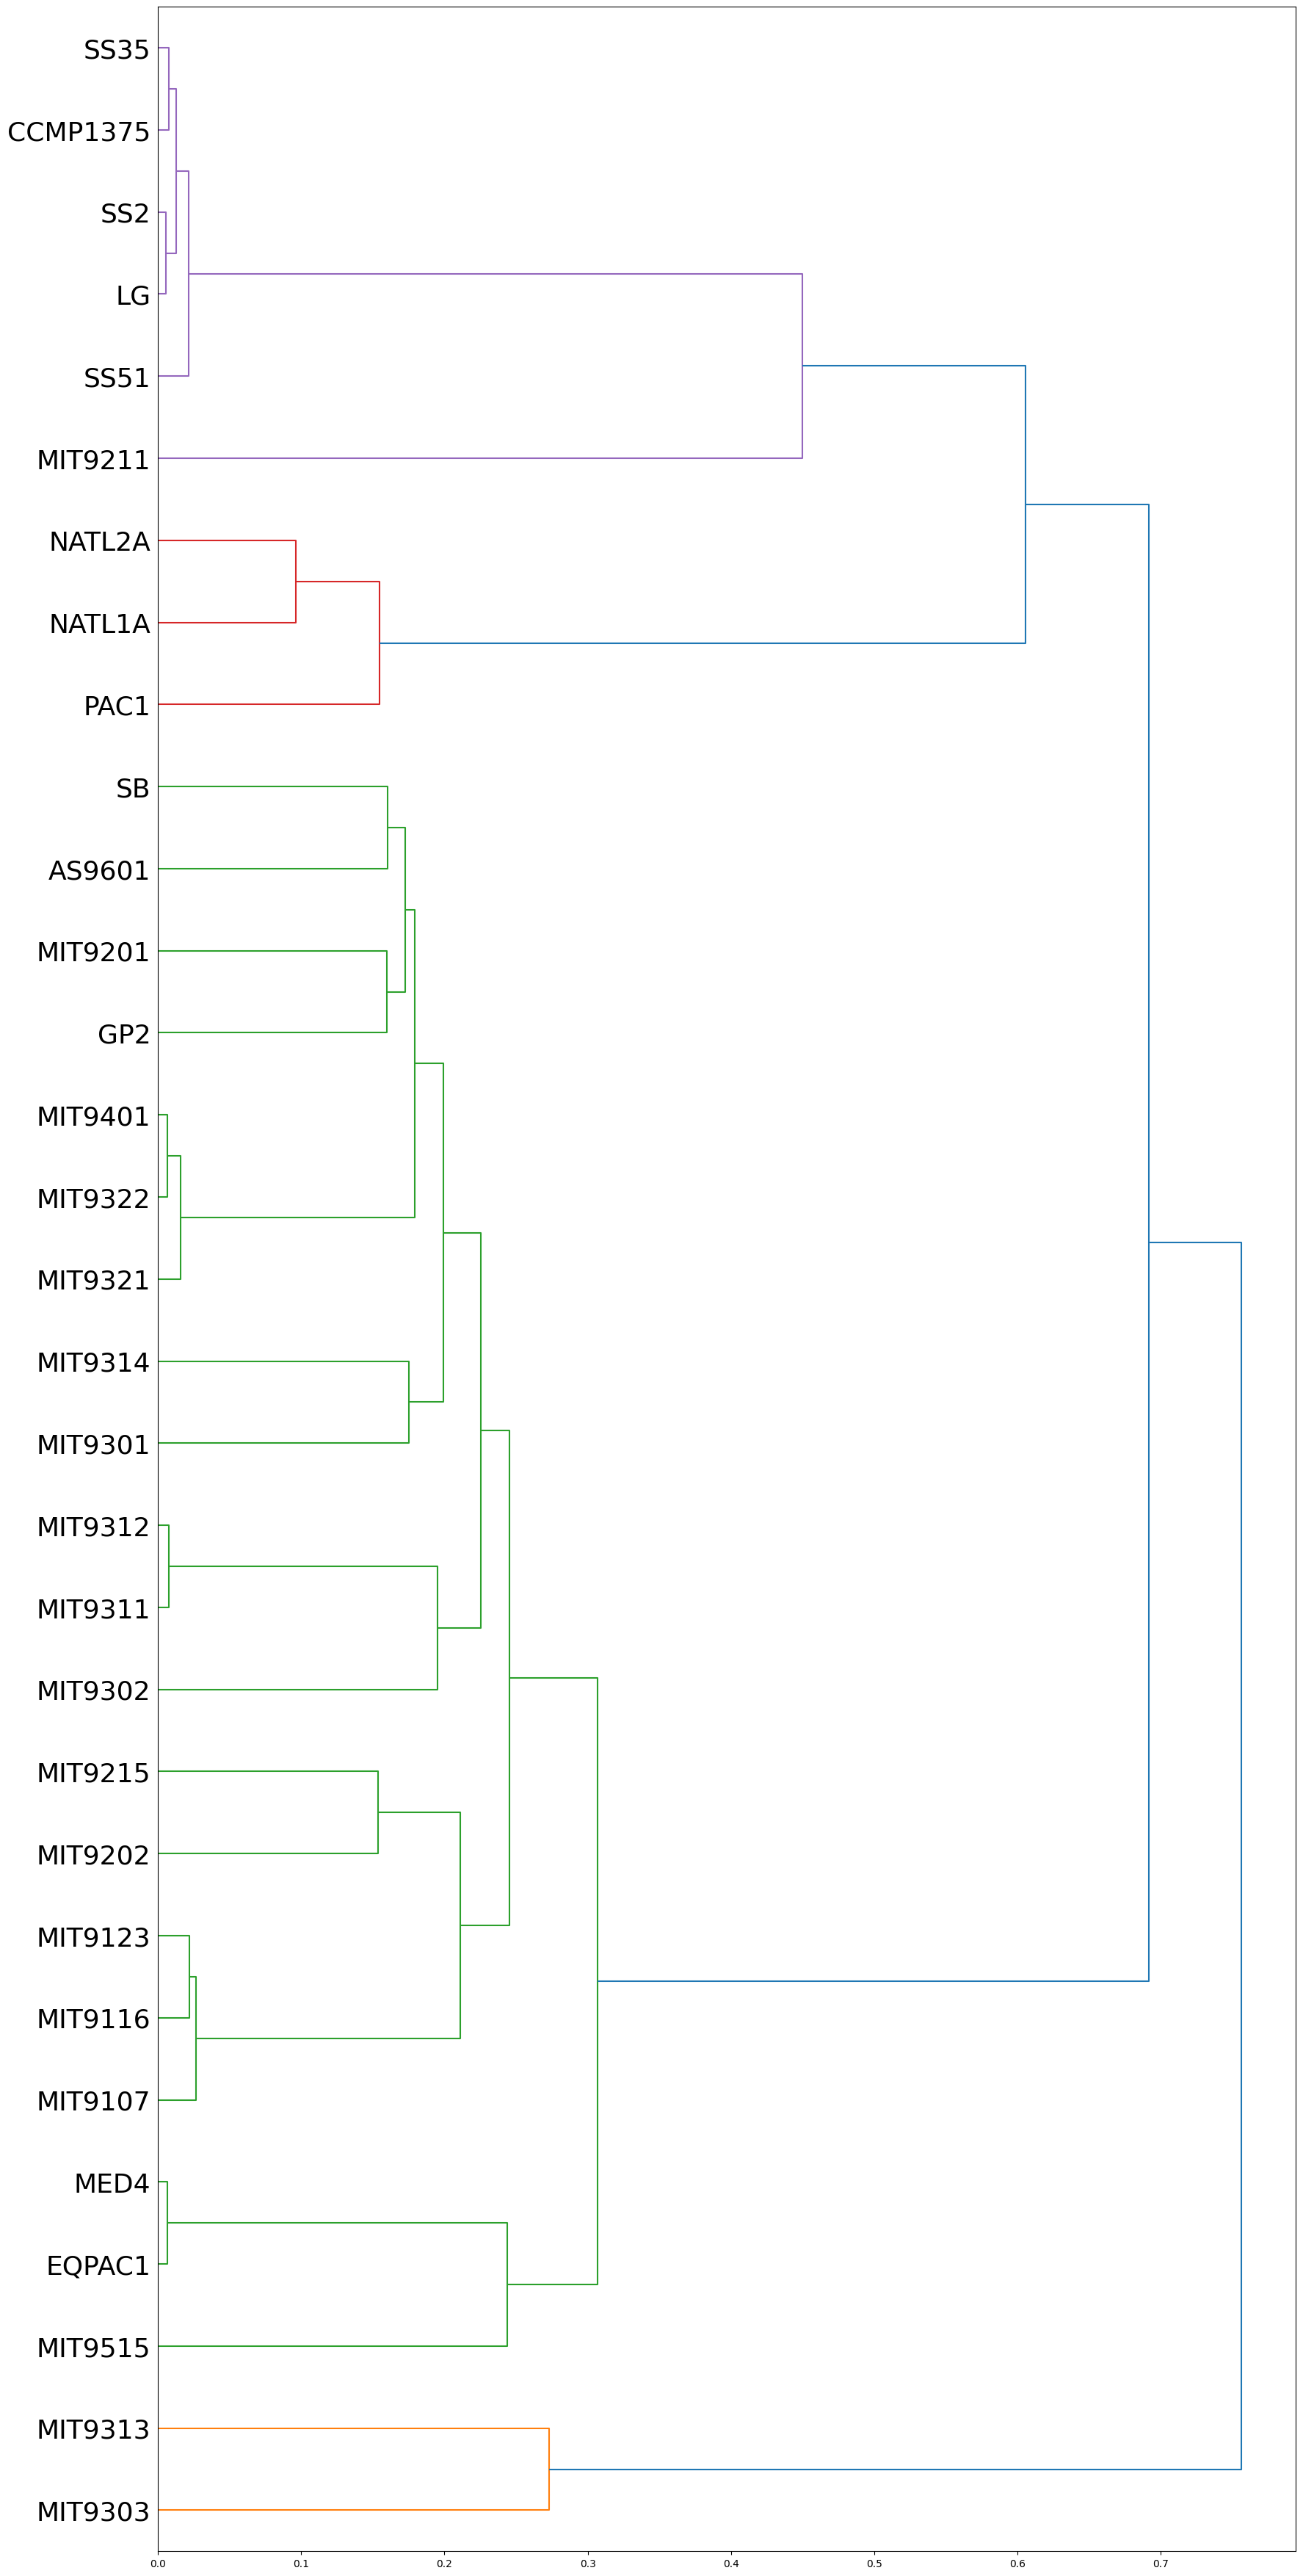

In [18]:
plt.figure(figsize=(20, 45))
dendro = dendrogram(col_linkage, labels=pivot_df.columns, orientation='right', leaf_font_size=26)

# plt.savefig("../figures/png/gene_clusters_clustergram_genome.png", format='png', bbox_inches='tight')
# plt.savefig("../figures/svg/gene_clusters_clustergram_genome.svg", format='svg', bbox_inches='tight')
# plt.savefig("../figures/pdf/gene_clusters_clustergram_genome.pdf", format='pdf', bbox_inches='tight')

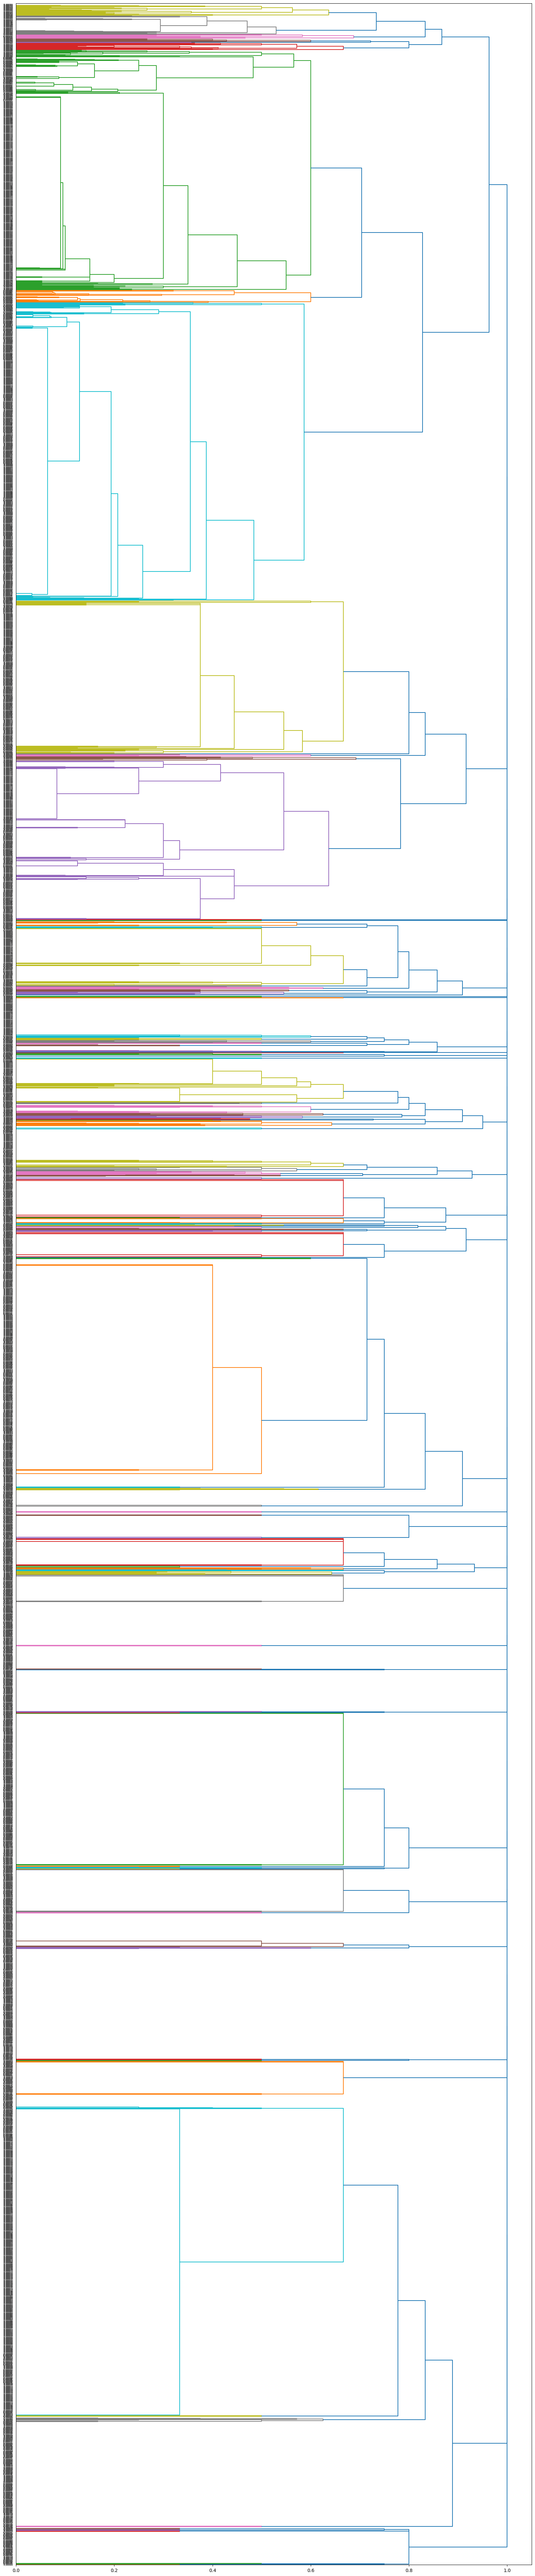

In [8]:
plt.figure(figsize=(20, 100))
dendro = dendrogram(row_linkage, labels=pivot_df.index, orientation='right', leaf_font_size=3)

# plt.savefig("../figures/png/gene_clusters_clustergram_gene_clusters.png", format='png', bbox_inches='tight')
# plt.savefig("../figures/svg/gene_clusters_clustergram_gene_clusters.svg", format='svg', bbox_inches='tight')
# plt.savefig("../figures/pdf/gene_clusters_clustergram_gene_clusters.pdf", format='pdf', bbox_inches='tight')

In [9]:
fig = go.Figure(data=go.Heatmap(
                   z=pivot_df_clustered.values,
                   y=pivot_df_clustered.index,
                   x=pivot_df_clustered.columns,
                   colorscale='Viridis',
                   showscale=False))

fig.update_layout(
    autosize=False,
    height=1500,  
    width=700,
)

fig.update_xaxes(tickangle=-90, side='top')

# fig.write_image("../figures/pdf/gene_clusters_heatmap.pdf")
# fig.write_image("../figures/png/gene_clusters_heatmap.png")
# fig.write_html("../figures/html/gene_clusters_heatmap.html")
# fig.show()

In [13]:
#empriical covariance matrix
S = pd.DataFrame(data=np.cov(pivot_df.values, bias=True), index=pivot_df.index, columns=pivot_df.index)

g = sns.clustermap(S.values)

g.savefig("../figures/png/cov_clustermap_gene_clusters.png", format='png', bbox_inches='tight')
g.savefig("../figures/svg/cov_clustermap_gene_clusters.svg", format='svg', bbox_inches='tight')
g.savefig("../figures/pdf/cov_clustermap_gene_clusters.pdf", format='pdf', bbox_inches='tight')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



### Stet 2: Inverse covariance estimation with SQUIC and StARS

In [3]:
import os 

from gglasso.solver.admm_solver import ADMM_MGL
from gglasso.solver.single_admm_solver import ADMM_SGL
from sklearn.model_selection import ShuffleSplit, train_test_split

os.environ['SQUIC_LIB_PATH'] = os.path.expanduser('~/anvio/')


In [4]:
conn = sqlite3.connect('../data/prochlorococcus/Prochlorococcus-PAN-PAN.db')

query = "SELECT * FROM gene_cluster_presence_absence"

df = pd.read_sql_query(query, conn)

conn.close()

In [5]:
pivot_df = df.pivot(index='layer', columns='item', values='value')

# transpose data
pivot_df = pivot_df.T
print("Data shape:", pivot_df.shape)
pivot_df.head()

Data shape: (7385, 31)


layer        AS9601  CCMP1375  EQPAC1  GP2  LG  MED4  MIT9107  MIT9116  \
item                                                                     
PC_00000001       1         1       1    1   1     1        1        1   
PC_00000002       1         1       1    1   1     1        1        1   
PC_00000003       1         1       1    1   1     1        1        1   
PC_00000004       1         0       1    1   0     1        1        1   
PC_00000005       1         1       1    1   1     1        1        1   

layer        MIT9123  MIT9201  ...  MIT9322  MIT9401  MIT9515  NATL1A  NATL2A  \
item                           ...                                              
PC_00000001        1        1  ...        1        1        1       1       1   
PC_00000002        1        1  ...        1        1        1       1       1   
PC_00000003        1        1  ...        1        1        1       1       1   
PC_00000004        1        1  ...        1        1        1       1       1   
PC_00000005        1        1  ...        1        1        1       1       1   

layer        PAC1  SB  SS2  SS35  SS51  
item                                    
PC_00000001     1   1    1     1     1  
PC_00000002     1   1    1     1     1  
PC_00000003     1   1    1     1     1  
PC_00000004     1   1    0     0     0  
PC_00000005     1   1    1     1     1  

[5 rows x 31 columns]

In [6]:
X = pivot_df.copy()
lambdas = np.logspace(-2, 0, 4)

# Initialize a list to store the stability scores for each alpha
stability_scores = []

n_subsamples = 100

In [ ]:
# Initialize the ShuffleSplit because we need subsampling without replacement Liu et al. 2010
ss = ShuffleSplit(n_splits=n_subsamples, test_size=0.2)

for lambda1 in lambdas:
    # Initialize a list to store the estimated graphs for each subsample
    precision_list = []

    for train_index, _ in ss.split(X):
        # Generate a 0.8 subsample of the data
        X_train = X.values[train_index]

        # Calculate the empirical pxp covariance matrix
        X_transpose = X_train.T
        S = np.cov(X_transpose, bias=True)

        sol, _ = ADMM_SGL(S, lambda1=0.1, Omega_0=np.eye(31), max_iter=1000, tol=1e-4, verbose=True)

        precision_list.append(sol['Theta'])

    # # Calculate the stability score for this alpha value
    # stability_score = np.mean([np.all(precision_list[i] == precision_list[j]) for i in range(n_subsamples) for j in range(i+1, n_subsamples)])
    # stability_scores.append(stability_score)
        
    # best_alpha = alphas[np.argmax(stability_scores)]

In [28]:
from scipy.special import comb

def _calculate_adj_matrix(data):
    """
    Calculate the adjacency matrix from the given inverse covaraince matrix ('Theta').

    If the edge matrix is of floating point type, an element in 'Theta' is considered an edge (True in the adjacency matrix) 
    if its absolute value is greater than machine epsilon. Otherwise, an element is considered an edge if it's not equal to zero.

    Parameters:
    data (np.array): A 2D numpy array representing Theta.

    Returns:
    np.array: A 2D boolean numpy array representing the adjacency matrix.
    """
    if np.issubdtype(data.dtype, np.floating):
        _eps = np.finfo(dtype=data.dtype).eps
        return np.abs(data) > _eps
    else:
        return data != 0

def stars(precision_list, p):
    """
    Calculate the total instability of a set of estimated precision matrices.

    The instability of each edge is calculated as the variance of a Bernoulli distribution, 2p(1-p), where p is the average edge value.
    The total instability is the average instability over all possible edges.

    Parameters:
    precision_list (list of np.array): A list of 2D numpy arrays representing the estimated precision matrices.
    p (int): The number of variables or nodes in the graphical model.

    Returns:
    float: The total instability of the estimated precision matrices.
    """
    edges = [_calculate_adj_matrix(Theta) for Theta in precision_list]
    edge_average = np.mean(edges, axis=0) # average edge value over all subsamples
    edge_instability = 2 * edge_average * (1 - edge_average) # instability of each edge, i.e., the variance of a Bernoulli distribution 2p(1-p)
    total_instability = np.sum(edge_instability) / comb(p, 2) / 2 # average instability over all edges for a given lambda
    return total_instability


print(stars(precision_list, 31))


0.0


In [18]:
sol, info = ADMM_SGL(S, lambda1=0.1, Omega_0=np.eye(31), max_iter=1000, tol=1e-4, verbose=True)

------------ADMM Algorithm for Single Graphical Lasso----------------
iter	       r_t	       s_t	   eps_pri	  eps_dual
   0	     1.341	     3.223	   0.05046	   0.04973
   1	     0.964	      2.03	   0.05066	   0.04982
   2	    0.2843	     1.613	   0.05081	   0.04984
   3	   0.08938	     1.464	   0.05095	   0.04984
   4	   0.04472	     1.128	   0.05117	   0.04984
   5	   0.03182	    0.8134	    0.0515	   0.04984
   6	    0.0271	    0.5383	   0.05192	   0.04984
   7	     0.025	    0.3231	   0.05243	   0.04984
   8	   0.02394	    0.1714	   0.05297	   0.04984
   9	   0.02267	    0.1038	   0.05329	   0.04984
  10	   0.02141	   0.06726	    0.0535	   0.04984
  11	   0.02022	   0.04542	   0.05363	   0.04984
ADMM terminated after 12 iterations with status: optimal.


### Step 3: Gene level frequencies

|           |         | GC1 | GC2 | GC3 | ... | GC_7385 |
|-----------|---------|-----|-----|-----|-----|-----|
| genome_1  | gene_1  |     |     |     |     |     |
|           | gene_2  |     |     |     |     |     |
|           | ...     |     |     |     |     |     |
|           | gene_n  |     |     |     |     |     |
| ...       | ...     |     |     |     |     |     |
|-----------|---------|-----|-----|-----|-----|-----|
| genome_k  | gene_1  |     |     |     |     |     |
|           | gene_2  |     |     |     |     |     |
|           | ...     |     |     |     |     |     |
|           | gene_p  |     |     |     |     |     |

In [19]:
df = pd.read_csv('../data/prochlorococcus/gene_cluster_frequencies.txt', sep='\t')


pivot_df = df.pivot(index='layer', columns='item', values='value')

# transpose data
pivot_df = pivot_df.T
print("Data shape:", pivot_df.shape)
pivot_df.head()

Data shape: (7385, 31)


layer        AS9601  CCMP1375  EQPAC1  GP2  LG  MED4  MIT9107  MIT9116  \
item                                                                     
PC_00000001      10         3      10    8   4    13        7        7   
PC_00000002       2         8       1    2   8     1        2        2   
PC_00000003       3         3       3    3   3     3        3        3   
PC_00000004       3         0       3    3   0     4        3        3   
PC_00000005       2         1       3    2   1     3        2        2   

layer        MIT9123  MIT9201  ...  MIT9322  MIT9401  MIT9515  NATL1A  NATL2A  \
item                           ...                                              
PC_00000001        7        9  ...        7        7       12      18      16   
PC_00000002        2        2  ...        2        2        2       7       7   
PC_00000003        3        3  ...        3        3        3       3       3   
PC_00000004        3        2  ...        3        3        4       4       3   
PC_00000005        2        2  ...        2        2        2       1       1   

layer        PAC1  SB  SS2  SS35  SS51  
item                                    
PC_00000001    11   8    4     3     4  
PC_00000002     7   2    8     8     8  
PC_00000003     3   3    3     3     3  
PC_00000004     2   3    0     0     0  
PC_00000005     1   2    1     1     1  

[5 rows x 31 columns]

In [10]:
pivot_df

layer        AS9601  CCMP1375  EQPAC1  GP2  LG  MED4  MIT9107  MIT9116  \
item                                                                     
PC_00000001      10         3      10    8   4    13        7        7   
PC_00000002       2         8       1    2   8     1        2        2   
PC_00000003       3         3       3    3   3     3        3        3   
PC_00000004       3         0       3    3   0     4        3        3   
PC_00000005       2         1       3    2   1     3        2        2   
...             ...       ...     ...  ...  ..   ...      ...      ...   
PC_00007381       0         0       0    0   0     0        0        0   
PC_00007382       0         0       0    0   0     0        0        0   
PC_00007383       0         0       0    0   0     0        0        0   
PC_00007384       0         0       0    0   0     0        0        0   
PC_00007385       0         0       0    0   0     0        0        0   

layer        MIT9123  MIT9201  ...  MIT9322  MIT9401  MIT9515  NATL1A  NATL2A  \
item                           ...                                              
PC_00000001        7        9  ...        7        7       12      18      16   
PC_00000002        2        2  ...        2        2        2       7       7   
PC_00000003        3        3  ...        3        3        3       3       3   
PC_00000004        3        2  ...        3        3        4       4       3   
PC_00000005        2        2  ...        2        2        2       1       1   
...              ...      ...  ...      ...      ...      ...     ...     ...   
PC_00007381        0        0  ...        0        0        0       0       0   
PC_00007382        0        0  ...        0        0        0       0       0   
PC_00007383        0        0  ...        0        0        0       0       0   
PC_00007384        0        0  ...        0        0        0       0       0   
PC_00007385        0        0  ...        0        0        0       0       0   

layer        PAC1  SB  SS2  SS35  SS51  
item                                    
PC_00000001    11   8    4     3     4  
PC_00000002     7   2    8     8     8  
PC_00000003     3   3    3     3     3  
PC_00000004     2   3    0     0     0  
PC_00000005     1   2    1     1     1  
...           ...  ..  ...   ...   ...  
PC_00007381     0   0    0     0     0  
PC_00007382     0   0    0     0     0  
PC_00007383     0   0    0     0     0  
PC_00007384     0   0    0     0     0  
PC_00007385     0   0    0     0     0  

[7385 rows x 31 columns]

In [20]:
conn = sqlite3.connect('../data/prochlorococcus/Prochlorococcus-PAN-GENOMES.db')

query = "SELECT * FROM gene_info"

genes_df = pd.read_sql_query(query, conn)

conn.close()

In [21]:
genes_df

genome_name  gene_caller_id  \
0          AS9601               0   
1          AS9601               1   
2          AS9601               2   
3          AS9601               3   
4          AS9601               4   
...           ...             ...   
60218        SS51           60218   
60219        SS51           60219   
60220        SS51           60220   
60221        SS51           60221   
60222        SS51           60222   

                                             aa_sequence  \
0      MEIICNQNELNNAIQLVSKAVASRPTHPILANILLTADEGTNKISV...   
1      MVLNYGNGENVWMHPPVHRILGWYSRPSNFDLKRNVWRLNQITQII...   
2      MINHENNDLFDLNEALKVENLTLNDYEEICKRLKRKPNRTELGMFG...   
3      MCGIVGIVSSNDVNQQIYDSLLLLQHRGQDSTGIATMENTVFHIHK...   
4      MDKKNFTSISLQEEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...   
...                                                  ...   
60218  MPPTVKTFSQIIRQFFAVLISFAIIFSISAEPLIALNDGQQLVLET...   
60219  MANSSPVYDWFQERLEIQDIADDVTSKYVPPHVNIFYCLGGITLVC...   
60220  MSTLKKPNLSDPKLRAKLSKGMGHNYYGEPAWPNDLLYIFPVVILG...   
60221  MPERFSQQRQRVRPNSNEEAVVKRAQEHFERSLIKINGHLAGSVAA...   
60222  MTGSEISESHKKIFLVHSLEPLNNFKEAQTTILYASAVISGFKQVILRY   

                                            dna_sequence  partial  length  
0      ATGGAAATTATTTGTAATCAAAATGAATTAAATAATGCTATACAAC...        0     385  
1      ATGGTCCTTAATTATGGAAATGGTGAAAATGTTTGGATGCATCCTC...        0     215  
2      ATGATAAATCATGAAAATAATGATCTATTTGATCTTAATGAAGCAT...        0     779  
3      ATGTGCGGAATAGTTGGAATCGTTTCTTCGAATGATGTAAATCAAC...        0     486  
4      ATGGATAAGAAAAATTTCACTTCCATATCACTTCAAGAAGAAATGC...        0     813  
...                                                  ...      ...     ...  
60218  ATGCCTCCAACTGTAAAAACCTTTTCACAAATTATCCGGCAATTTT...        1     208  
60219  ATGGCGAACTCCTCACCTGTCTACGACTGGTTCCAGGAACGACTTG...        0     218  
60220  ATGTCCACTCTAAAGAAACCAAATTTATCTGATCCAAAGCTAAGGG...        0     160  
60221  ATGCCAGAAAGATTTAGTCAACAGCGCCAAAGAGTGCGGCCAAATT...        0     481  
60222  ATGACCGGATCTGAGATCTCGGAAAGTCACAAGAAAATATTCTTAG...        0      49  

[60223 rows x 6 columns]